<center> <h1> <strong>RiceInspect</strong></h1></center>
<br>


RiceInspect is a computer vision based software that identifies the quality of rice grains. It looks over rice images containing sample of rice grains and analyze the size, color, quality, of rice grains. It also look over broken, dusted rice grains and various other features of rice.

RiceInspect is faster, precise when it comes to compariosn of traditional Rice quality checking technique that implements manual human checking.

RiceInspect provide a comprehensive assessment of the sample. With accurate and automated detection of broken grains and other quality parameters, the software can help rice processors optimize their production processes, reduce waste, and ensure consistent quality of their products. Additionally, the software can provide detailed reports and statistics on rice quality, which can be useful for quality assurance and compliance purposes.


### Objectives:
* Objective 1: Count the number of rice grains in the Image.👌 Done
* Objective 2: Find the number of broken grains in the image. 
* Objective 3: Calculate area of each rice grain. 👌 Done
* Objective 4: Identify the color of rice grain.


---
# Image Information
* The background will always be black.
* There will be a mix of broken and non-broken rice grains.
* The grains will not overlap but can touch each other.

# Source Code

In [1]:
#Importing openCv both as cv2 and cv for better convinence  
import cv2 as cv
import cv2 as cv2

# Importing numpy for working with numpy arrays
import numpy as np 

# Importing pyplot as plt from maplotlib for Image Visualization
from matplotlib import pyplot as plt 

# #Collab not support cv2.imshow method thus, importing cv2.imshow method for better Image visualization 
# from google.colab.patches import cv2_imshow  

#Importing PIL library for working with Images
from PIL import Image 

#Importing asarray method from numpy for dealing with pixels of Images
from numpy import asarray 

import matplotlib.image as mpimg

#Importing ndimage from scipy as this package contains various functions for multidimensional image processing.
from scipy import ndimage

#Importing filters, features, measures and color from skimage
from skimage import filters, feature, measure, color

#Importing Watershed for touching Grains sepration
from skimage.segmentation import watershed


def show(image,x=40,y=7):
  plt.figure(figsize=(x,y))
  plt.imshow(image,cmap="gray")


def read_image(path):
    src = cv.imread(path)
    height, width, channels = src.shape 
    if float(height) > float(width):
        src = cv.rotate(src, cv.ROTATE_90_CLOCKWISE)
    return src


def gray_scale(img,thres=100):
    #thres-120
    #Converting Image BGR Image to Gray for Image thresholding and further Image-Preprocessing application
    grayscale_Image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, thresh_img = cv.threshold(grayscale_Image, thres, 255, cv.THRESH_BINARY)
    return thresh_img



def noise_removal(img,unit=2):
    # Noise removal
    #unit=3
    kernel = np.ones((unit),np.uint8)
    clear_image = cv.morphologyEx(img,cv.MORPH_OPEN, kernel, iterations=8)

    #Using show function earlier defined
    return clear_image


def visualize_images(img,noise):
    # Provide Image path here
    show(img)

    #Gray Scale Image
    gray_img=gray_scale(img)

    #Noise removed Image
    clear_img=noise_removal(gray_img,noise)
    show(clear_img)

    Rice_area,lables = water_shed(clear_img,0.10)

    plt.figure(figsize=(30,10))
    plt.imshow(color.label2rgb(lables, bg_label=0))
    



def applying_contour(img):
    
    #Applying Countours method to get the count of rice grains
    contours, hierarchy = cv.findContours(img, 
                                          cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    output_contour = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
    return output_contour



def Rice_size(img):
    rice_size=[]
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Calculate the equivalent diameter of each rice based on its area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 15: # filter out small contours
            continue
        eq_diameter = np.sqrt(4 * area / np.pi)
        # Convert the equivalent diameter to millimeters
        pixel_size = 0.09  # assume each pixel is 0.014 mm (you can adjust this based on your image)
        eq_diameter_mm = eq_diameter * pixel_size
        rice_size.append(eq_diameter_mm)

        # Print the equivalent diameter of each rice in millimeters
#         print("Rice size:", eq_diameter_mm, "mm")
    return rice_size



def calculate_object_areas(labels,pixel_size):
    object_areas = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == 0:  # Exclude the background label
            continue
        object_mask = labels == label
        area = np.sum(object_mask)
        if area < 50: # filter out small contours
            continue
        eq_diameter = np.sqrt(4 * area / np.pi)

        # Convert the equivalent diameter to millimeters
        #pixel_size = 0.10  # assume each pixel is 0.014 mm (you can adjust this based on your image)
        eq_diameter_mm = eq_diameter * pixel_size
        object_areas.append(round(eq_diameter_mm,3))
                            
    return object_areas




def water_shed(img,pixel_size):
    # To visualize the segmentation conveniently, there is a need to color-code the labelled regions.

    # Applying distance_transform_edt to compute the distance from non-zero (i.e., non-background) points to the nearest zero (i.e., background) point.
    dist_trans = ndimage.distance_transform_edt(img)

    # Applying peak_local_max function to get coordinates of local peaks (maxima) in an image.
    local_max = feature.peak_local_max(dist_trans, min_distance=22)

    local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
    local_max_mask[tuple(local_max.T)] = True

    # Applying Watershed algorithm
    labels = watershed(-dist_trans, measure.label(local_max_mask), mask=img)  # separate merged objects
    
    object_areas = calculate_object_areas(labels,pixel_size)
#     plt.imshow(color.label2rgb(labels, bg_label=0))
    
    return object_areas, labels




def riceAnalysis(clear_img,brokenRiceSize,pixel_size):
    # Area of each rice grains
    Rice_area,lables = water_shed(clear_img,pixel_size)

    print("\n\nTotal rice grain count as per contour is: ",len(Rice_area))

    print("\n")

    TotalRiceAreaSum=0
    for count in range(0,len(Rice_area)):
        print("Area of the rice grain",count+1, "is:",Rice_area[count])
        TotalRiceAreaSum+=Rice_area[count]



    print("\nRice Analysis :")
    #Average area of rice 
    print("Average area of rice is: ", round(TotalRiceAreaSum/len(Rice_area),3)," mm")


    #Broken Rice count
    BrokenRiceCount=0;
    brokenRiceArea=0;
    for rice in Rice_area:
        if rice < brokenRiceSize:
            brokenRiceArea+=rice
            BrokenRiceCount+=1

    print("Broken Rice count is: ",BrokenRiceCount)

    #Percentage of rice grain Broken
    print("Percentage of rice grain broken is :",round((brokenRiceArea/TotalRiceAreaSum),3),"% percent")

    #. (brokens area/total rice+brokens area)

def riceInspect(img,noise,brokenRiceSize,pixel):
    clear_img=noise_removal(gray_scale(read_image(img)),noise)
    riceAnalysis(clear_img,brokenRiceSize,pixel)
       

# Implementation

### riceInspect(image_path  ,  broken_rice_size_in_mm  ,  noise_level  ,  pixel_value)

In [4]:
img ="samples/test_black_full1.jpg"
riceInspect(img,3,2,0.10)



Total rice grain count as per contour is:  221


Area of the rice grain 1 is: 2.988
Area of the rice grain 2 is: 3.541
Area of the rice grain 3 is: 3.883
Area of the rice grain 4 is: 3.565
Area of the rice grain 5 is: 5.16
Area of the rice grain 6 is: 3.443
Area of the rice grain 7 is: 3.561
Area of the rice grain 8 is: 4.799
Area of the rice grain 9 is: 3.463
Area of the rice grain 10 is: 3.127
Area of the rice grain 11 is: 3.379
Area of the rice grain 12 is: 4.512
Area of the rice grain 13 is: 3.478
Area of the rice grain 14 is: 3.423
Area of the rice grain 15 is: 3.597
Area of the rice grain 16 is: 3.785
Area of the rice grain 17 is: 3.123
Area of the rice grain 18 is: 3.648
Area of the rice grain 19 is: 3.523
Area of the rice grain 20 is: 3.62
Area of the rice grain 21 is: 3.545
Area of the rice grain 22 is: 3.265
Area of the rice grain 23 is: 3.311
Area of the rice grain 24 is: 5.959
Area of the rice grain 25 is: 3.511
Area of the rice grain 26 is: 3.78
Area of the rice grain 27

### Visualize here 

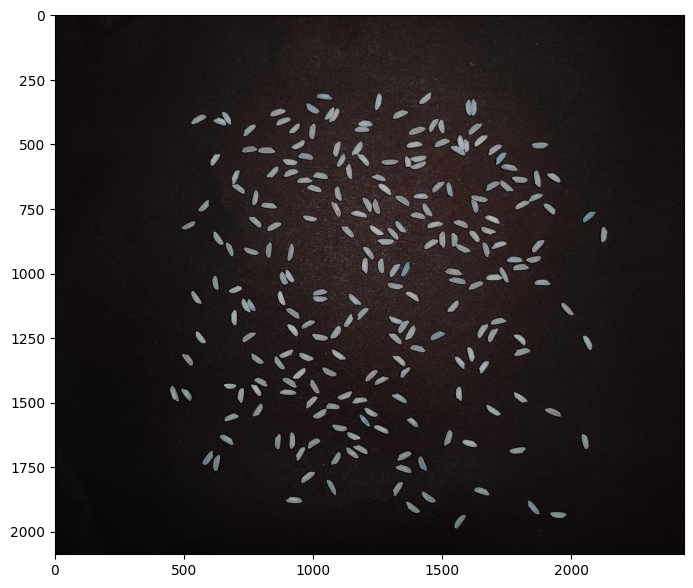

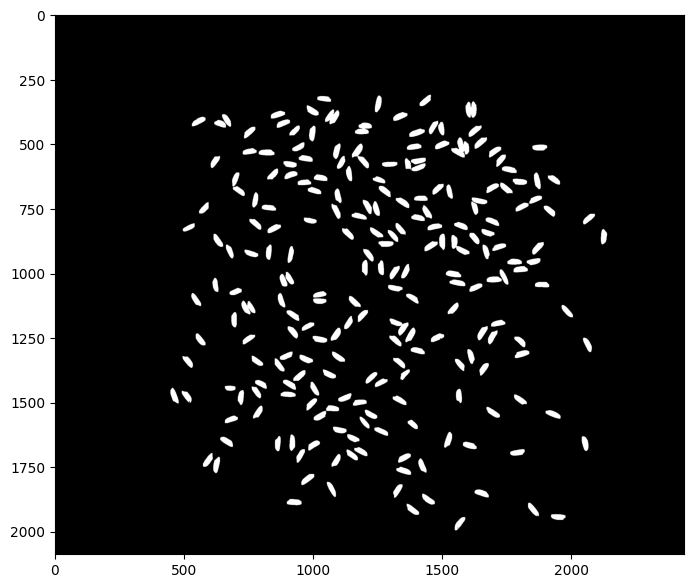

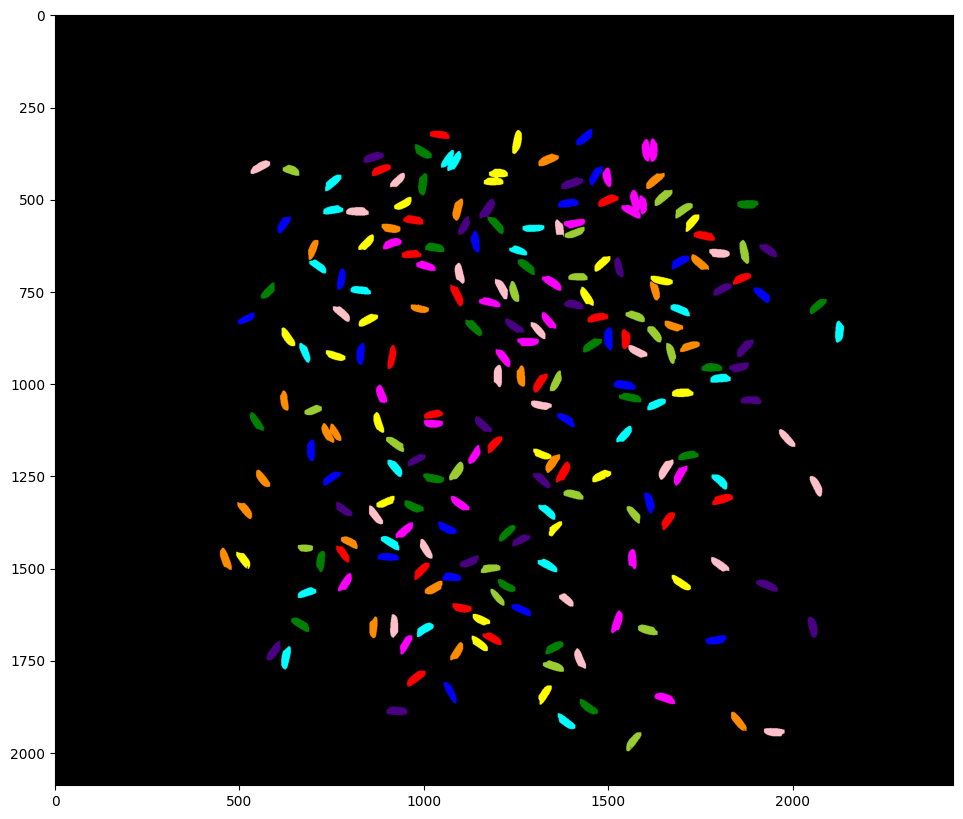

In [5]:
visualize_images(read_image(img),2)

In [ ]:
2017

i5 intel 

### Visualizing the Results

## Bad rice grains (based on Color)

In [10]:
img=cv.imread("RiceBlackBackground3.jpg")

def check_pixel_color_inside_contour(img, contour):

  # Convert the image to grayscale.
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get the mask of the contour.
    mask = cv2.drawContours(np.zeros_like(grayscale_image), [contour], 0, 255, -1)

    # Find the minimum and maximum pixel values in the mask.
    min_color = np.min(grayscale_image[mask])
    max_color = np.max(grayscale_image[mask])

In [19]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Check the pixel color inside the contours.
for contour in contours:
    min_color, max_color = check_pixel_color_inside_contour(img, contour)
    print("The minimum color inside the contour is {} and the maximum color is {}.".format(min_color, max_color))
    

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
